In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([nn.Conv2d(2, 32, 3, 1, padding='same')] + [nn.Conv2d(32, 32, 3, 1, padding='same') for i in range(10)] + [nn.Conv2d(32, 3, 3, 1, padding='same')])

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.layers[i](x)
            x = F.relu(x)
        out = self.layers[-1](x)
        loc = out[:,0,:,:]
        scale=torch.exp(out[:,1,:,:])
        df = torch.exp(out[:,2,:,:])
        return loc, scale, df

In [16]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20,200)
        self.p_layer = nn.Linear(200,1)
        self.n_layer = nn.Linear(200,1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = F.hardtanh(x) + x
        p = self.sig(self.p_layer(x))
        n = torch.exp(self.n_layer(x))
        return torch.cat((p*n,(1-p)*n),axis=-1)

In [17]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.orthogonal_layer = nn.Linear(input_size, input_size)
        nn.init.orthogonal_(self.orthogonal_layer.weight)
        nn.init.zeros_(self.orthogonal_layer.bias)
        self.layers = nn.ModuleList(
            [nn.Linear(input_size,400)] + [nn.Linear(400,400) for i in range(6)])
        self.p_layer = nn.Linear(400,1)
        self.n_layer = nn.Linear(400,1)
        # torch.nn.init.orthogonal_(self.p_layer.weight, gain=.01)
        # torch.nn.init.zeros_(self.p_layer.bias)
        # torch.nn.init.orthogonal_(self.n_layer.weight, gain=.01)
        # torch.nn.init.zeros_(self.n_layer.bias)


    def forward(self, x):
        x = self.orthogonal_layer(x)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = F.hardtanh(x) + x
        p = torch.sigmoid(self.p_layer(x))
        n = torch.exp(self.n_layer(x))
        return torch.cat((p*n,(1-p)*n),axis=-1)
        # alpha = torch.sigmoid(self.p_layer(x))
        # beta = torch.exp(self.n_layer(x))
        # return torch.cat((alpha, beta),axis=-1)

In [18]:
torch.FloatTensor([1]).mean()

tensor(1.)

In [19]:
def log_likelihood_loss(alpha, beta, target_alpha, target_beta):
    # print(alpha)
    # print(beta)
    # print(target_alpha)
    # print(target_beta)
    loss = -(
        (alpha-1)*(torch.digamma(target_alpha)-torch.digamma(target_alpha+target_beta)) + 
        (beta-1) *(torch.digamma(target_beta) -torch.digamma(target_alpha+target_beta)) -
        torch.lgamma(alpha)-torch.lgamma(beta)+torch.lgamma(alpha+beta)).mean()
    euler_mascheroni = 0.57721066
    regularizer = target_alpha*(torch.log(1/beta)+(1-beta)*(-euler_mascheroni)+(beta-1)*(1-euler_mascheroni)) + \
                  target_beta*(torch.log(1/alpha)+(1-alpha)*(-euler_mascheroni)+(alpha-1)*(1-euler_mascheroni))
    annealing_coefficient = .1
    return (loss + regularizer*annealing_coefficient).mean()

In [20]:
def reverse_log_likelihood_loss(alpha, beta, target_alpha, target_beta):
    loss = -(
        (target_alpha-1)*(torch.digamma(alpha)-torch.digamma(alpha+beta)) + 
        (target_beta-1) *(torch.digamma(beta) -torch.digamma(alpha+beta))
        -torch.lgamma(target_alpha)-torch.lgamma(target_beta)+torch.lgamma(target_alpha+target_beta)).mean()
    euler_mascheroni = 0.57721066
    regularizer = target_alpha*(torch.log(1/beta)+(1-beta)*(-euler_mascheroni)+(beta-1)*(1-euler_mascheroni)) + \
                  target_beta*(torch.log(1/alpha)+(1-alpha)*(-euler_mascheroni)+(alpha-1)*(1-euler_mascheroni))
    annealing_coefficient = 1
    return (loss + regularizer*annealing_coefficient).mean()

In [21]:
def cross_entropy_loss(alpha, beta, target_alpha, target_beta):
    return -(target_alpha*(torch.digamma(alpha)-torch.digamma(alpha+beta)) + target_beta*(torch.digamma(beta)-torch.digamma(alpha+beta))).sum()

In [22]:
def regularized_mse_loss(alpha, beta, target_alpha, target_beta):
    s_hat = alpha+beta
    p_hat = alpha/s_hat
    loss = (target_alpha+target_beta)*2*p_hat*(1-p_hat)/(s_hat+1) + 2*target_alpha*(1-p_hat)**2 + 2*target_beta*p_hat**2
    euler_mascheroni = 0.57721066
    regularizer = target_alpha*(torch.log(1/beta)+(1-beta)*(-euler_mascheroni)+(beta-1)*(1-euler_mascheroni)) + \
                  target_beta*(torch.log(1/alpha)+(1-alpha)*(-euler_mascheroni)+(alpha-1)*(1-euler_mascheroni))
    annealing_coefficient = 1
    # print(loss/target_alpha+target_beta)
    # print(regularizer)
    return (loss + annealing_coefficient * regularizer).mean()

In [23]:
input_size = 20
network = Net(input_size)

In [24]:
len(list(network.parameters()))

20

In [31]:
optimizer = torch.optim.SGD(network.parameters(), lr=1e-5)
batch_size = 10
p=.5
running_loss = 0
running_evidence = 0
bayes_risk_loss = 0
running_p_hat_loss = 0
gamma = .999
while True:
    optimizer.zero_grad()
    inpt = torch.bernoulli(torch.ones(batch_size,input_size)*p)
    # print(inpt)
    out = network(inpt)
    alpha, beta = out[:,:1], out[:,1:]
    # print(alpha)
    # print(beta)
    # print(out)
    # print(inpt.mean(axis=1))
    mean = torch.ones(batch_size)*inpt.mean(axis=1)
    target = torch.bernoulli(mean)
    # print(target)
    # print(target)
    # print(target*alpha/(alpha+beta)*(torch.digamma(alpha+1)-torch.digamma(alpha + beta + 1)))
    # print((1-target)*beta/(alpha+beta)*(torch.digamma(beta+1)-torch.digamma(alpha + beta + 1)))
    # loss = -(target*alpha/(alpha+beta)*(torch.digamma(alpha+1)-torch.digamma(alpha + beta + 1)) + (1-target)*beta/(alpha+beta)*(torch.digamma(beta+1)-torch.digamma(alpha + beta + 1)))
    # loss = log_likelihood_loss(alpha, beta, target+1, 1-target+1)
    # loss = log_likelihood_loss(alpha, beta, alpha.detach()+target, beta.detach() + (1-target))
    # loss = regularized_mse_loss(alpha, beta, target, 1-target)
    # loss = reverse_log_likelihood_loss(alpha, beta, target+1, 1-target+1)
    loss = cross_entropy_loss(alpha, beta, target+1, 1-target+1)
    # print('loss')
    running_loss = running_loss *gamma +loss*(1-gamma)
    running_evidence = running_evidence*gamma +(alpha+beta).mean()*(1-gamma)
    running_p_hat_loss = running_p_hat_loss*gamma + ((alpha/(alpha+beta)-mean)**2).mean()*(1-gamma)
    # bayes_risk_loss = bayes_risk_loss *gamma +log_likelihood_loss(alpha, beta, target+1, (1-target)+1)*(1-gamma)
    print(f'running loss:{running_loss}')
    # print(f'bayes risk loss:{bayes_risk_loss}')
    print(f'running p_hat loss:{running_p_hat_loss}')
    print(f'running evidence:{running_evidence}')
    # print(torch.exp(-loss))
    loss.backward()
    optimizer.step()

running loss:0.20934872329235077
running p_hat loss:7.2918564910651185e-06
running evidence:0.22928833961486816
running loss:0.421674519777298
running p_hat loss:4.8724083171691746e-05
running evidence:0.44267982244491577
running loss:0.6306016445159912
running p_hat loss:5.7127072068396956e-05
running evidence:0.67670077085495
running loss:0.8411033153533936
running p_hat loss:7.256326352944598e-05
running evidence:0.9459352493286133
running loss:1.0509686470031738
running p_hat loss:8.616659033577889e-05
running evidence:1.3513129949569702
running loss:1.2764253616333008
running p_hat loss:0.00010504758392926306
running evidence:1.696439504623413
running loss:1.5487430095672607
running p_hat loss:0.00019854043785016984
running evidence:1.95597505569458
running loss:1.8426622152328491
running p_hat loss:0.0003048632643185556
running evidence:2.149564027786255
running loss:2.10688853263855
running p_hat loss:0.00041968494770117104
running evidence:2.3859477043151855
running loss:2.3350

KeyboardInterrupt: 

In [ ]:
torch.bernoulli(torch.ones(batch_size)*inpt.mean(axis=1))

In [ ]:
inpt.mean(axis=1)

In [ ]:
inpt.mean(axis=1)

In [ ]:
inpt = torch.bernoulli(torch.ones(1,input_size)*p)
print(inpt)
print(inpt.mean())
out = network(inpt)
print(out)
print(out[0,0]/out.sum())

In [ ]:
out[0,0]/out.sum()

Text(0, 0.5, 'p_hat')

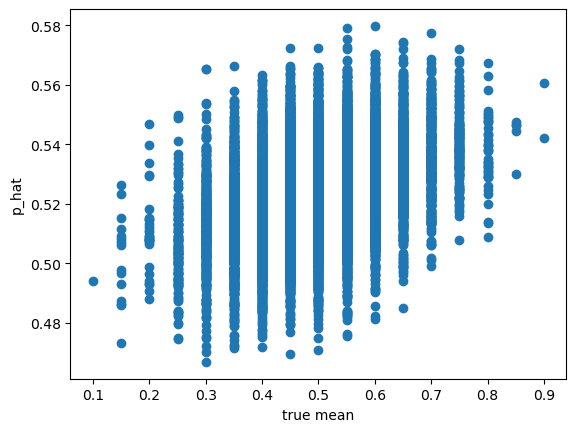

In [32]:
means = []
p_hats = []
evidences = []
for i in range(10000):
    inpt = torch.bernoulli(torch.ones(1,input_size)*p)
    out = network(inpt)
    means.append(inpt.mean().item())
    p_hats.append((out[0,0]/out.sum()).item())
    evidences.append(out.sum().item())
plt.scatter(means, p_hats)
plt.xlabel('true mean')
plt.ylabel('p_hat')

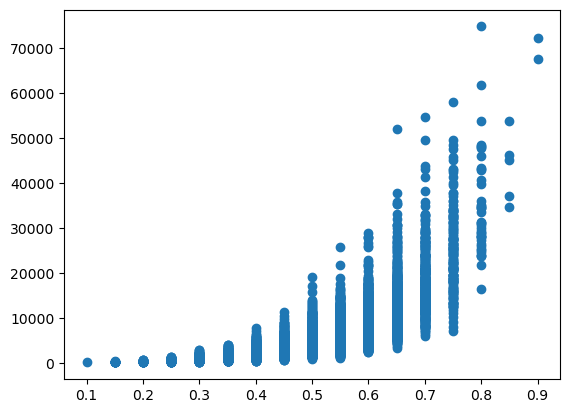

In [33]:
plt.scatter(means, evidences)

In [28]:
import pandas as pd

In [34]:
a = pd.DataFrame({'means':means, 'evidences': evidences})

In [35]:
a.groupby(means)['evidences'].mean()

0.10      210.587799
0.15      241.022624
0.20      396.268558
0.25      616.876305
0.30      983.584163
0.35     1383.934745
0.40     2028.928298
0.45     2977.954052
0.50     4265.051431
0.55     5959.393293
0.60     8565.502997
0.65    12279.422691
0.70    17931.712085
0.75    24663.850483
0.80    34938.710347
0.85    43449.647656
0.90    69890.808594
Name: evidences, dtype: float64

In [ ]:
plt.yscale('log')
plt.scatter(np.array(evidences),(np.array(means)-np.array(p_hats))**2)